In [2]:
from sklearnex import patch_sklearn

patch_sklearn()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0,'..')
import module as mod

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Import et nettoyage des données

In [5]:
house1_power_blk2 = mod.load_dataset('house1_power_blk2_labels.zip')
house1_power_blk2.head()

mains  activity  hour
datetime                                  
2016-03-06 00:00:00  473.0         0   0.0
2016-03-06 00:00:01  474.0         0   0.0
2016-03-06 00:00:02  476.0         0   0.0
2016-03-06 00:00:03  476.0         0   0.0
2016-03-06 00:00:04  475.0         0   0.0

On peut essayer de voir quelle est la fenêtre de temps optimale pour nos features générées

In [3]:
all_windows = ['2min', '5min', '10min', '30min', '1h', '2h', '3h', '5h', '12h']
house1_power_blk2, features_cols = mod.generate_features(house1_power_blk2, window=all_windows)

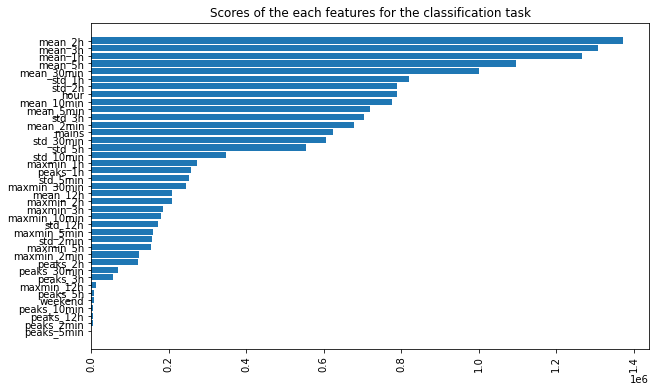

In [20]:
# ideally this would be done after a split test / train
fs = SelectKBest()
all_features = ['mains', 'hour'] + features_cols
fs.fit_transform(house1_power_blk2.loc[:, all_features].values, house1_power_blk2.loc[:, 'activity'].values)

sorted_scores_idx = np.argsort(fs.scores_)

fig = plt.figure(figsize=(10, 6))
plt.barh(y=np.array(all_features)[sorted_scores_idx], width=fs.scores_[sorted_scores_idx]);
#plt.bar(x=range(len(fs.scores_)), height=fs.scores_);
plt.xticks(rotation=90)
plt.title('Scores of the each features for the classification task');

On peut également obtenir le même type de graphique en utilisant les coefficient de correlation de Pearson.

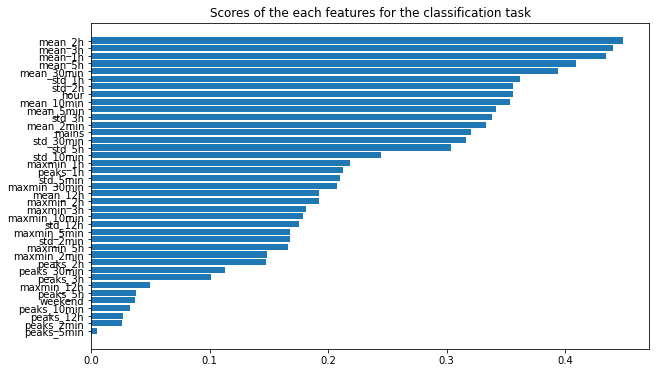

In [6]:
# ideally this would be done after a split test / train
all_features = ['mains', 'hour'] + features_cols
corr_scores = house1_power_blk2[all_features + ['activity']].corr().loc['activity', all_features].abs()

sorted_scores_idx = np.argsort(corr_scores)

fig = plt.figure(figsize=(10, 6))
plt.barh(y=np.array(all_features)[sorted_scores_idx], width=corr_scores[sorted_scores_idx]);
plt.title('Scores of the each features for the classification task');

2 heures semble optimal. Nous allons également choisir une deuxième fenêtre de 10 minutes pour avoir une fenêtre log terme et une fenêtre court terme.

In [4]:
best_windows = ['1h', '10min']
features_col = ['mains', 'hour', 'weekend'] + [func+window for window in best_windows for func in ['std_', 'mean_', 'maxmin_', 'peaks_']]

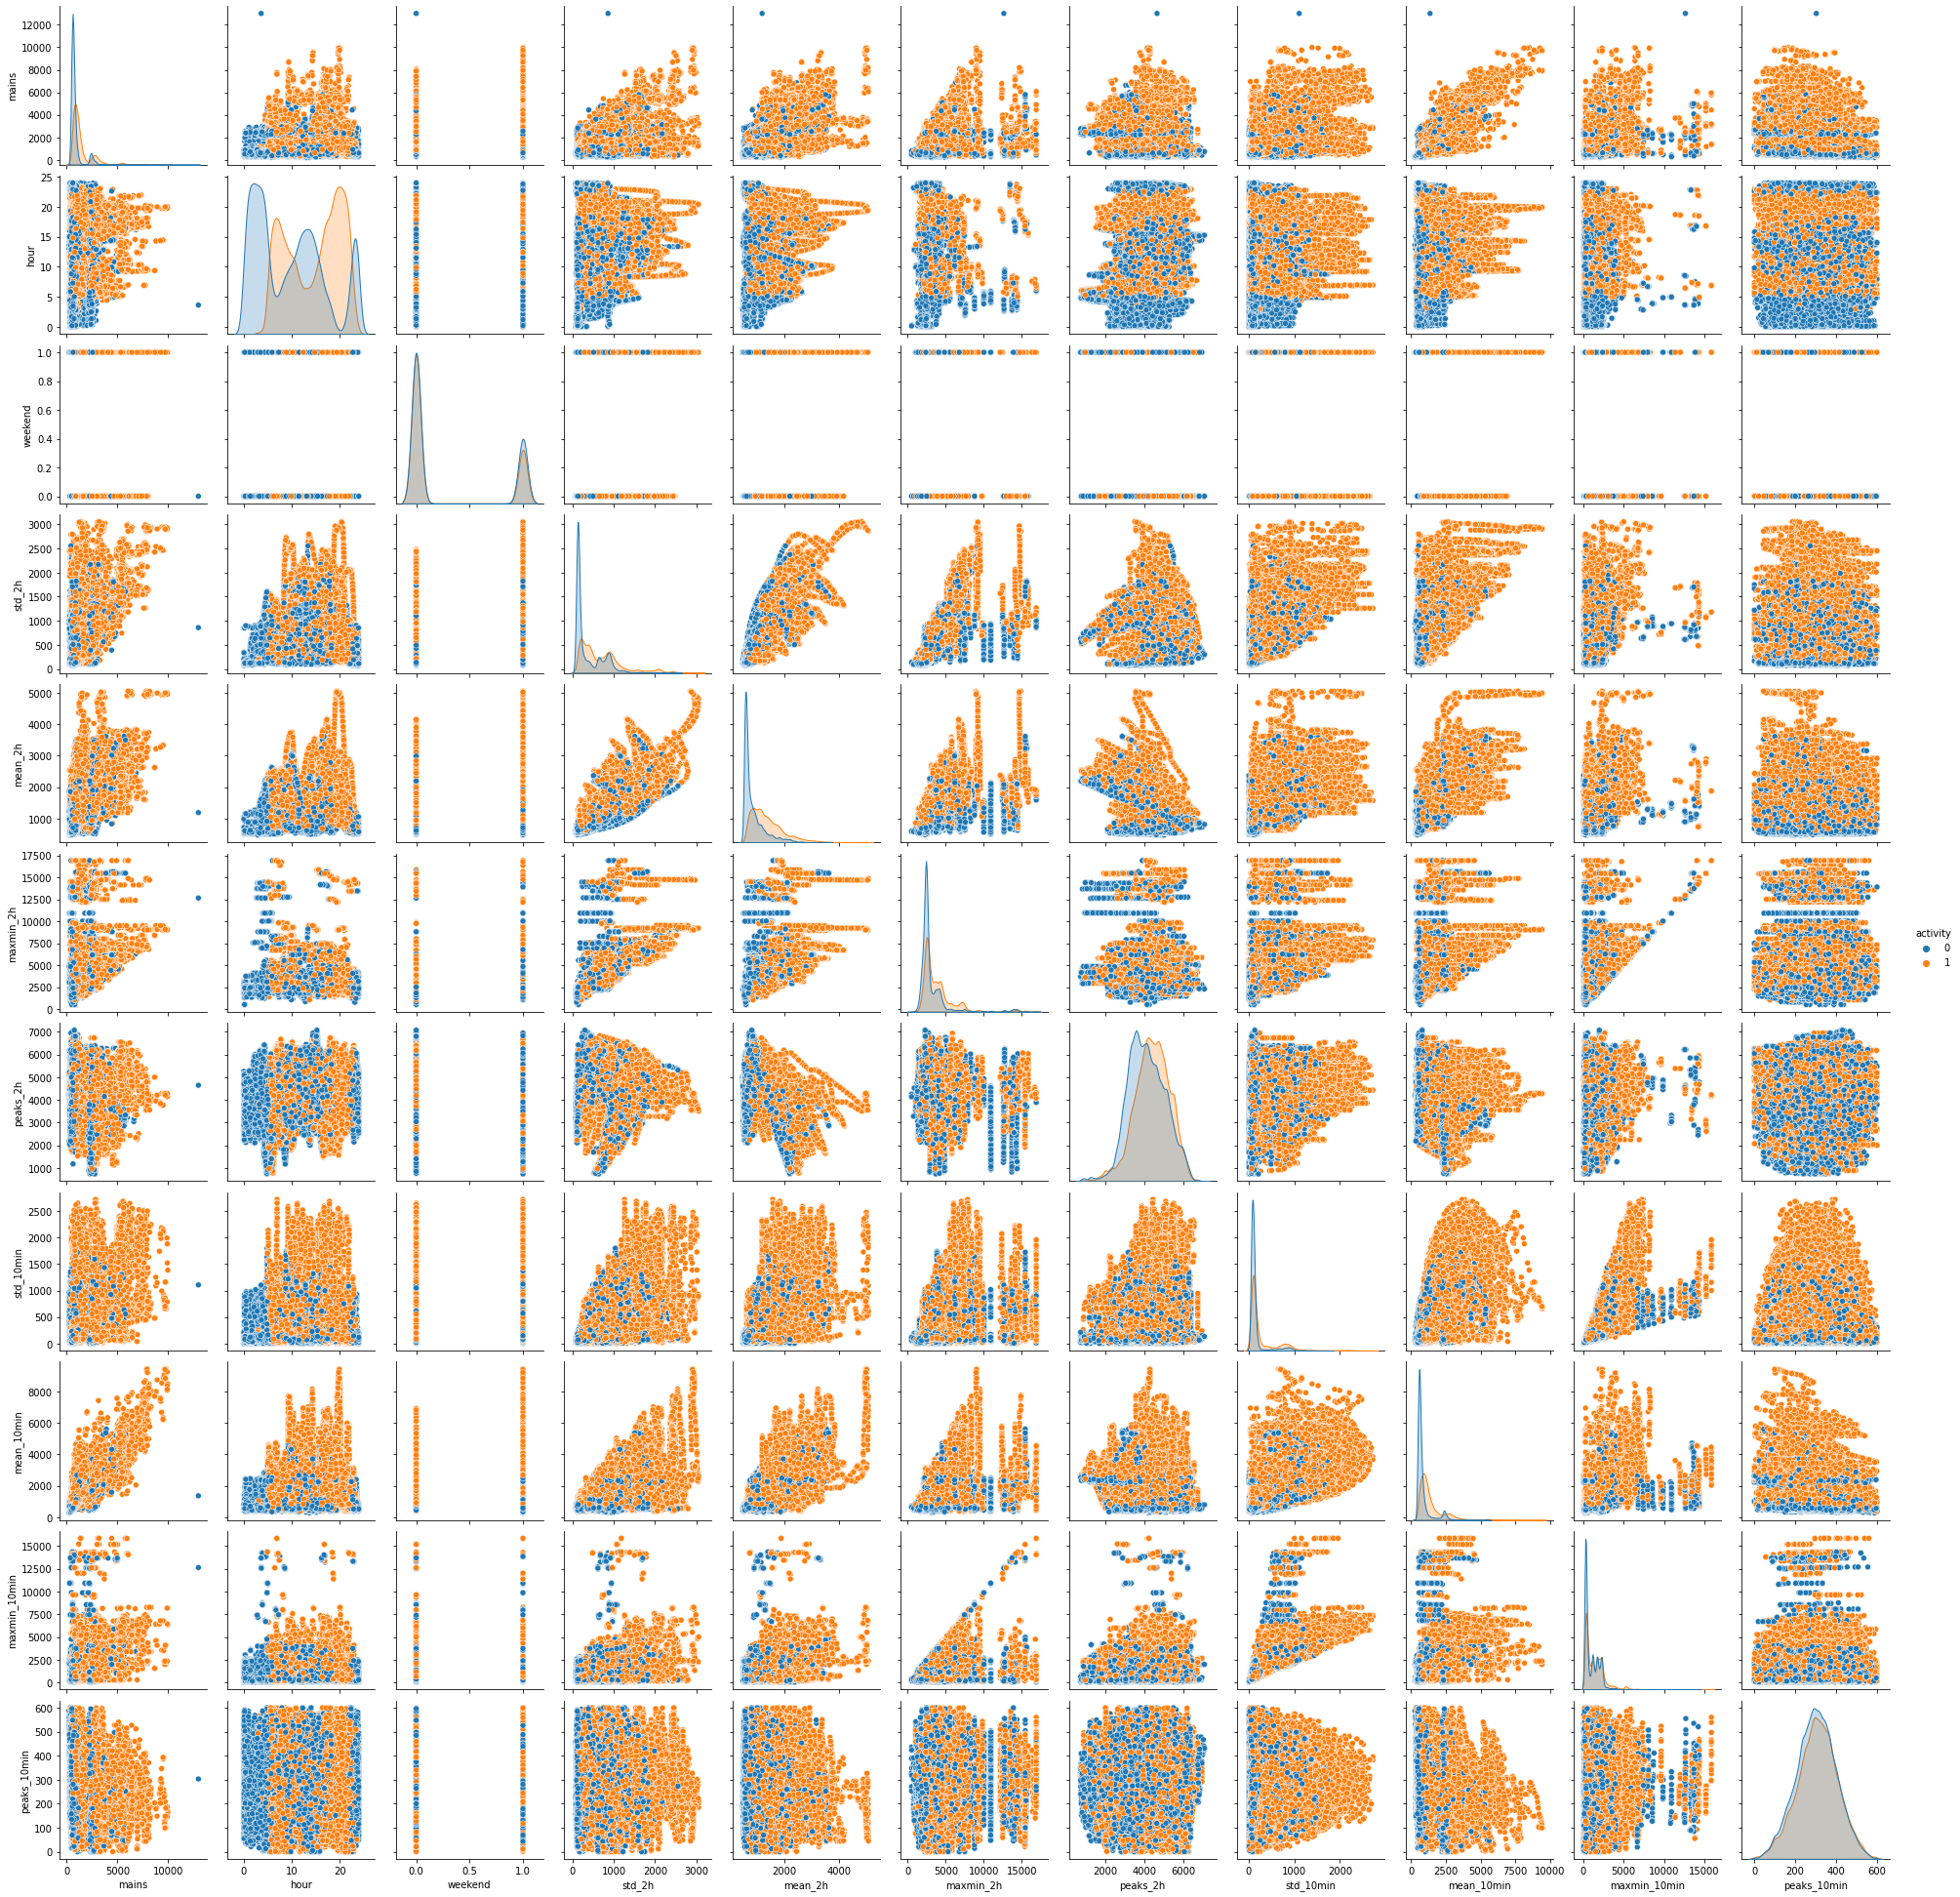

In [5]:
sns.pairplot(house1_power_blk2[features_col + ['activity']].sample(frac=0.05), hue='activity');

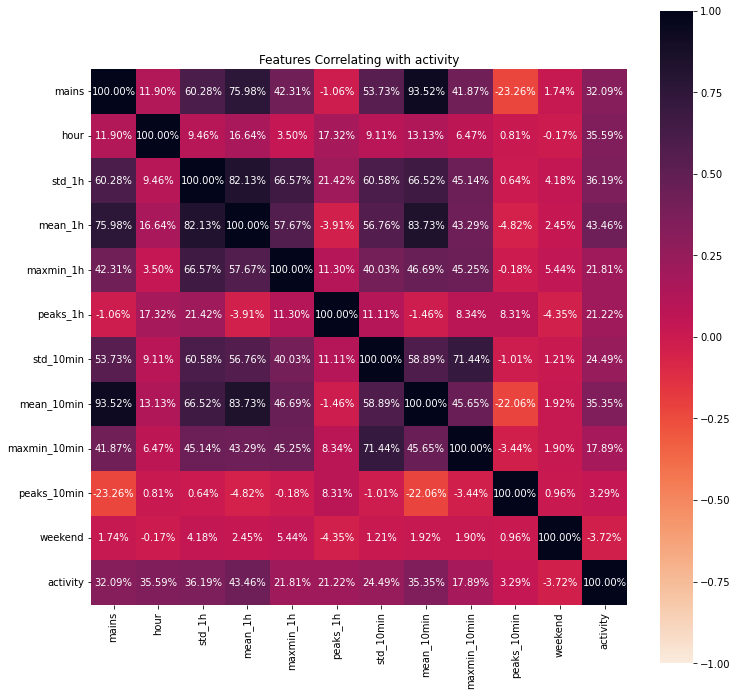

In [4]:
plt.figure(figsize=(12, 12))
ax = sns.heatmap(house1_power_blk2[features_col + ['activity']].corr(), vmin=-1, vmax=1, annot=True, fmt='.2%', square=True, cmap=sns.cm.rocket_r)
ax.set_title('Features Correlating with activity');

# 2. Train / test split

In [6]:
best_windows = ['1h', '10min']

house1_power_blk2, cols = mod.generate_features(house1_power_blk2, window=best_windows)
features_col = ['mains', 'hour'] + cols

X_train, X_test, y_train, y_test = mod.split_train_test_scale_df(house1_power_blk2, features_col)

# 3. Algorithmes généraux

tested n_neighbors=5 ...
tested n_neighbors=40 ...
tested n_neighbors=60 ...
tested n_neighbors=90 ...


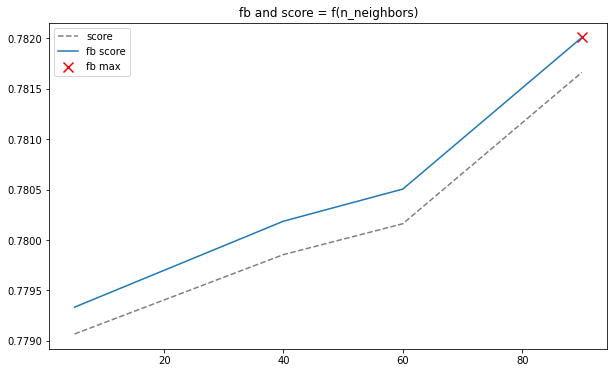

Meilleur fb score=0.78 obtenu pour n_neighbors=90.00
Score f_beta : 78.201%
Score accuracy : 78.166%


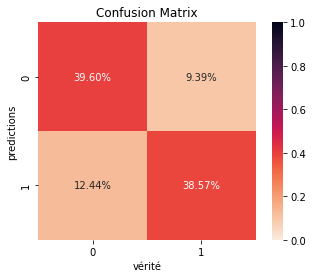

In [5]:
k_range = [5, 40, 60, 90]
mod.plot_scores_param(X_train, X_test, y_train, y_test, KNeighborsClassifier, 'n_neighbors', k_range);

tested n_estimators=1 ...
tested n_estimators=30 ...
tested n_estimators=60 ...
tested n_estimators=90 ...


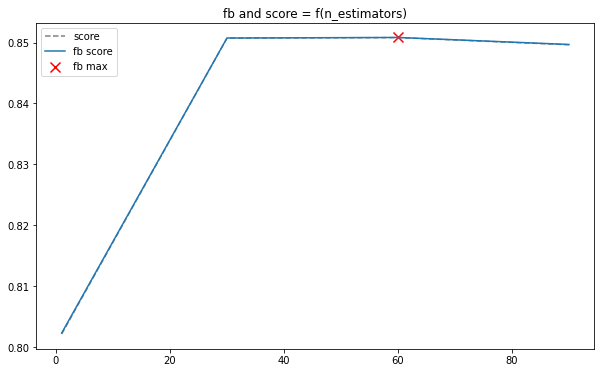

Meilleur fb score=0.85 obtenu pour n_estimators=60.00
Score f_beta : 84.803%
Score accuracy : 84.831%


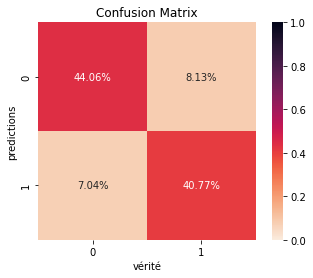

In [5]:
n_range = [1, 30, 60, 90]
mod.plot_scores_param(X_train, X_test, y_train, y_test, RandomForestClassifier, 'n_estimators', n_range, other_params={'n_jobs': -1, 'max_samples': 0.8, 'max_depth': 10});

tested max_depth=20 ...
tested max_depth=40 ...
tested max_depth=60 ...
tested max_depth=80 ...


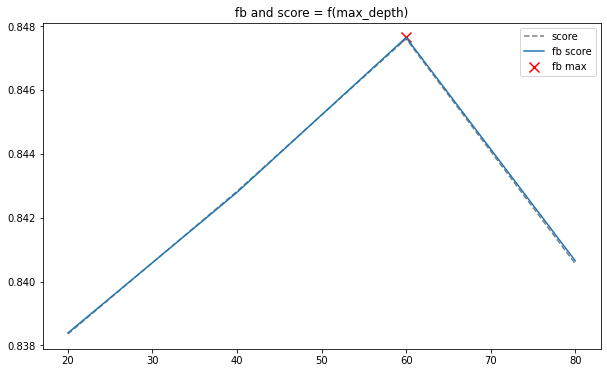

Meilleur fb score=0.85 obtenu pour max_depth=60.00
Score f_beta : 85.009%
Score accuracy : 84.992%


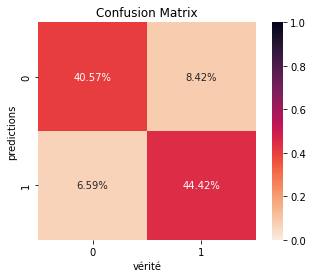

In [4]:
n_range = [20, 40, 60, 80]
mod.plot_scores_param(X_train, X_test, y_train, y_test, HistGradientBoostingClassifier, 'max_depth', n_range, other_params={'max_iter': 300});

In [4]:
# c_range = np.linspace(1, 5, 6)
# mod.plot_scores_param(X_train, X_test, y_train, y_test, SVC, 'C', c_range)
svc = SVC()
svc.fit(X_train, y_train.ravel())
y_pred = svc.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

### 3.1 Analyse des résultats
Nous allons faire un train/test split en découpant le jeu de données chronologiquement plutôt que par jours aléatoires.

Score f_beta : 72.946%
Score accuracy : 73.536%


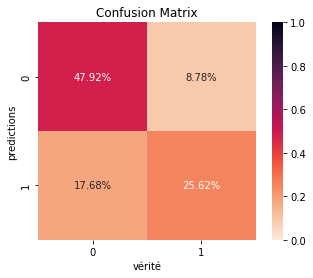

In [7]:
train_dim = int(0.7*len(house1_power_blk2))
# train_dim_h2 = int(0.7*len(house2_power_blk1))
X_train, X_test = house1_power_blk2.iloc[:train_dim]['mains'].values, house1_power_blk2.iloc[train_dim:]['mains'].values
y_train, y_test = house1_power_blk2.iloc[:train_dim]['activity'].values, house1_power_blk2.iloc[train_dim:]['activity'].values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 1))
X_test = scaler.transform(X_test.reshape(-1, 1))

classifier = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12)
classifier.fit(X_train, y_train.ravel())
y_pred = classifier.predict(X_test)

mod.plot_confusion_matrix(y_test, y_pred);

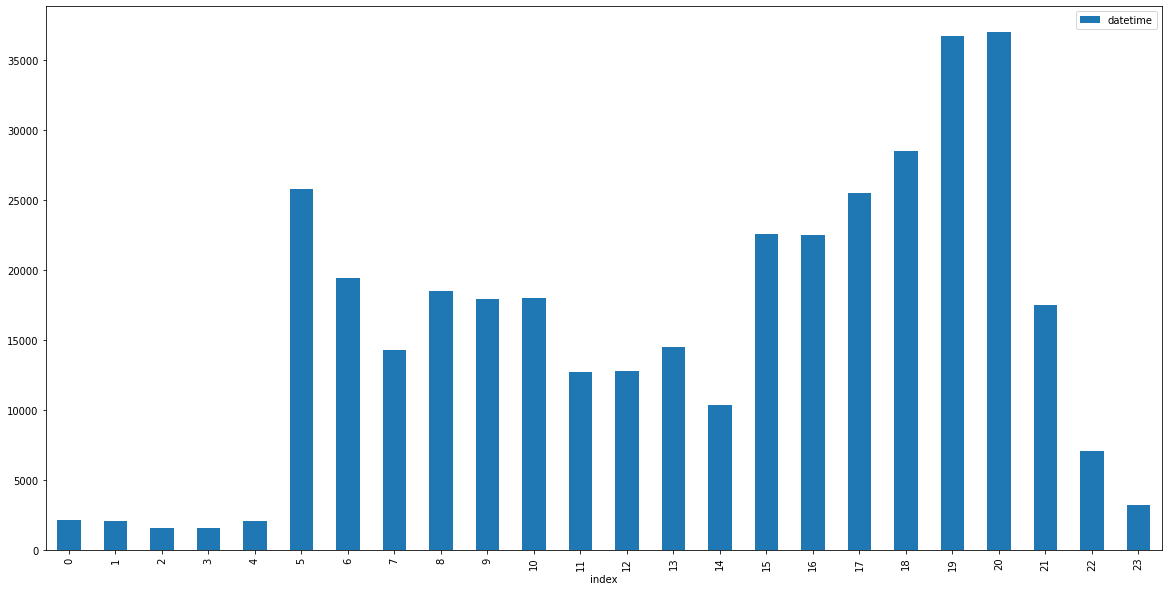

In [10]:
house1_power_blk2_res = house1_power_blk2.copy()
house1_power_blk2_res['activity_pred'] = np.nan
house1_power_blk2_res['activity_pred'].iloc[train_dim:] = (y_pred > 0.5).astype(int)
house1_power_blk2_res.iloc[train_dim:].head()

pd.DataFrame(house1_power_blk2_res[house1_power_blk2_res['activity_pred'] > 0].index.hour.value_counts()).reset_index(drop=False).sort_values(by='index').plot.bar(x='index', y='datetime', figsize=(20,10), legend='Histogramme activité=f(heure)');

/home/pierre/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


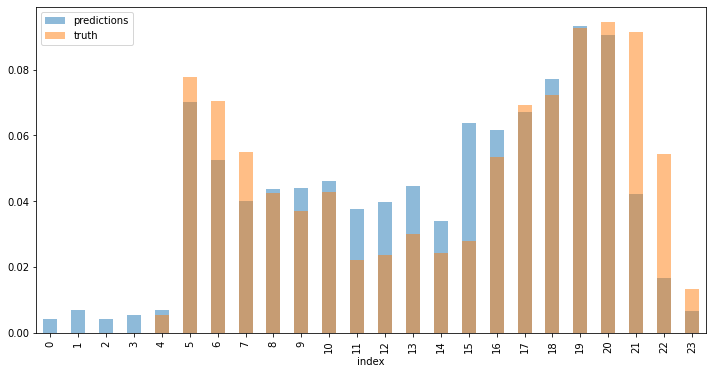

In [8]:
house1_power_blk2_res = house1_power_blk2.copy()
house1_power_blk2_res['activity_pred'] = np.nan
house1_power_blk2_res['activity_pred'].iloc[train_dim:] = (y_pred > 0.5).astype(int)
house1_power_blk2_res.iloc[train_dim:].head()

fig, ax = plt.subplots()
mod.plot_activity_hist(house1_power_blk2_res['activity_pred'].iloc[train_dim:], figsize=(12, 6), alpha=0.5, label='predictions', ax=ax)
mod.plot_activity_hist(house1_power_blk2['activity'].iloc[train_dim:], figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)

# 4. Algorithmes sur Time Series

First we convert the dataset into the correct format.

In [3]:
from tslearn.utils import to_time_series
from tslearn.preprocessing import TimeSeriesScalerMinMax

# we need to resample the data to 30min, otherwise it will be too big
house1_power_blk2_resampled = house1_power_blk2.resample('30min').mean()
train_indexes, test_indexes = mod.split_train_test_indexes(house1_power_blk2_resampled, 0.3)

# split train/test
X_train, X_test = to_time_series(house1_power_blk2_resampled.loc[train_indexes, 'mains']), to_time_series(house1_power_blk2_resampled.loc[test_indexes, 'mains'])
y_train, y_test = (house1_power_blk2_resampled.loc[train_indexes, 'activity'].values > 0.5)*1, (house1_power_blk2_resampled.loc[test_indexes, 'activity'].values > 0.5)*1

# scale
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We can now try a few algorithms.

In [26]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import fbeta_score, accuracy_score

knn = KNeighborsTimeSeriesClassifier(n_neighbors=3)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
print(fbeta_score(y_test, y_pred, average='macro', beta=0.5))
print(accuracy_score(y_test, y_pred))

/home/pierre/.local/lib/python3.8/site-packages/daal4py/sklearn/neighbors/_base.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)


0.27834919002314223
0.5011574074074074


In [4]:
from tslearn.svm import TimeSeriesSVC
from sklearn.metrics import fbeta_score, accuracy_score

svc = TimeSeriesSVC()
svc.fit(X_train, y_train.ravel())
y_pred = svc.predict(X_test)
print(fbeta_score(y_test, y_pred, average='macro', beta=0.5))
print(accuracy_score(y_test, y_pred))

/home/pierre/.local/lib/python3.8/site-packages/tslearn/metrics/softdtw_variants.py:40: RuntimeWarning: invalid value encountered in true_divide
  gram = - cdist(s1, s2, "sqeuclidean") / (2 * sigma ** 2)
/home/pierre/.local/lib/python3.8/site-packages/tslearn/metrics/softdtw_variants.py:40: RuntimeWarning: invalid value encountered in true_divide
  gram = - cdist(s1, s2, "sqeuclidean") / (2 * sigma ** 2)


ValueError: The gamma value of 0.0 is invalid. Use 'auto' to set gamma to a value of 1 / n_features.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from dtw import dtw

def dtw_dist(x,y):
    d = dtw(x, y)
    return d.distance

knn = KNeighborsClassifier(n_neighbors=3, metric=dtw_dist)
knn.fit(X_train.ravel().reshape((-1,1)), y_train.round().ravel())
knn.score(X_test.ravel().reshape((-1,1)), y_test.round().ravel())